#### Imports

In [475]:
#https://forecastegy.com/posts/time-series-clustering-python-scikit-learn/
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import plotly.express as px
import plotly.graph_objects as go
from openbb import obb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import polygon

In [476]:
from fredapi import Fred
fred_api_key = 'd640e0a4f2d8bdf668b5dad55d9b4ca6'
fred = Fred(api_key=fred_api_key)
# Now you can make FRED API requests using 'fred'


#### Read in market data

In [477]:
def create_dataframe():
    #ewa = australia, ewc = canada, inda = india, ewj = japan, ewl = switzerland, ewu = United Kingdom, eusa = USA, ewy = South Korea
	symbols = ['spy','ewa','ewz','ieur','ewc','inda','ewj','ewl','ewu','ewy']  #'i:fvx', 'i:tyx'
	start_date = '2020-01-03'
	mp = 7
	timespan = 'day'
	for symbol in symbols:
		tdf = polygon.get_data(start_date, symbol, timespan=timespan, multiplier=mp, silent=False)
		columns = tdf.columns.tolist()
		for col in columns:
			tdf.rename(columns={col: "%s_%s"%(symbol.lower(), col)}, inplace=True)
        	# Merge each instrument data into a master dataframe
			#check to see if date_time is in the columns and if not, pass
			#df = pd.merge_asof(df, tdf, left_index=True, right_index=True)
		if 'df' not in locals():
			# If df does not exist, create a new DataFrame named df
			df = tdf
		else:
			df = pd.concat([df, tdf], axis=1)
		# If df exists, concatenate tdf to df		
	#string_to_check = 'close'
	#columns_to_delete = [col for col in df.columns if 'close' not in col and 'volume' not in col]
	#df.drop(columns=columns_to_delete, inplace=True)
	return df

In [478]:
#possible ideas for Kmeans clustering of data.  
# https://medium.com/the-quant-journey/unsupervised-machine-learning-k-means-clustering-with-applications-in-finance-fbabd3f187f6

In [479]:
df = create_dataframe()

Downloaded SPY: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded EWA: 2020-01-03 05:00:00 - 2024-03-08 05:00:00


Downloaded EWZ: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded IEUR: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded EWC: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded INDA: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded EWJ: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded EWL: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded EWU: 2020-01-03 05:00:00 - 2024-03-08 05:00:00
Downloaded EWY: 2020-01-03 05:00:00 - 2024-03-08 05:00:00


In [480]:
# Create a list of column names that contain 'close'
close_columns = [col for col in df.columns if 'close' in col.lower()]

# Select only these columns from the DataFrame
df_close = df[close_columns]


In [481]:
df_close.head()

,spy_close,ewa_close,ewz_close,ieur_close,ewc_close,inda_close,ewj_close,ewl_close,ewu_close,ewy_close
date_time,,,,,,,,,,
2020-01-03 05:00:00,320.36,22.45,46.470,49.4300,29.770,34.37,59.070,40.540,33.701,60.27
2020-01-10 05:00:00,325.20,22.78,45.450,49.4200,29.995,35.60,59.430,40.365,33.520,62.49
2020-01-17 05:00:00,329.41,23.31,45.645,49.3900,30.290,35.24,59.420,41.330,33.500,62.64
2020-01-24 05:00:00,322.66,22.60,43.590,48.5099,29.870,34.67,58.075,40.720,32.820,58.58
2020-01-31 05:00:00,320.73,22.21,43.450,48.1300,29.610,33.95,57.560,40.600,32.390,57.26


In [482]:
df_close.columns

Index(['spy_close', 'ewa_close', 'ewz_close', 'ieur_close', 'ewc_close',
       'inda_close', 'ewj_close', 'ewl_close', 'ewu_close', 'ewy_close'],
      dtype='object')

In [483]:
def compute_past_values(row):
    past_values = {}
    for lag in range(21):
        for col in df.columns:
            past_values[f'{col}_lag_{lag}'] = row[col]
    return pd.Series(past_values)

# Apply the function to each row
#df_close = df.apply(compute_past_values, axis=1)

In [484]:
df_close.head()


,spy_close,ewa_close,ewz_close,ieur_close,ewc_close,inda_close,ewj_close,ewl_close,ewu_close,ewy_close
date_time,,,,,,,,,,
2020-01-03 05:00:00,320.36,22.45,46.470,49.4300,29.770,34.37,59.070,40.540,33.701,60.27
2020-01-10 05:00:00,325.20,22.78,45.450,49.4200,29.995,35.60,59.430,40.365,33.520,62.49
2020-01-17 05:00:00,329.41,23.31,45.645,49.3900,30.290,35.24,59.420,41.330,33.500,62.64
2020-01-24 05:00:00,322.66,22.60,43.590,48.5099,29.870,34.67,58.075,40.720,32.820,58.58
2020-01-31 05:00:00,320.73,22.21,43.450,48.1300,29.610,33.95,57.560,40.600,32.390,57.26


In [485]:
df_close.index

DatetimeIndex(['2020-01-03 05:00:00', '2020-01-10 05:00:00',
               '2020-01-17 05:00:00', '2020-01-24 05:00:00',
               '2020-01-31 05:00:00', '2020-02-07 05:00:00',
               '2020-02-14 05:00:00', '2020-02-21 05:00:00',
               '2020-02-28 05:00:00', '2020-03-06 05:00:00',
               ...
               '2024-01-05 05:00:00', '2024-01-12 05:00:00',
               '2024-01-19 05:00:00', '2024-01-26 05:00:00',
               '2024-02-02 05:00:00', '2024-02-09 05:00:00',
               '2024-02-16 05:00:00', '2024-02-23 05:00:00',
               '2024-03-01 05:00:00', '2024-03-08 05:00:00'],
              dtype='datetime64[ns]', name='date_time', length=219, freq=None)

In [486]:
# Select only these columns from the DataFrame
df_close_pct = df_close.pct_change().dropna() * 100
df_close_pct.to_parquet('df_diff.parquet', engine='pyarrow')

#### Set the country column as the index

In [487]:
df_close_pct.head()

,spy_close,ewa_close,ewz_close,ieur_close,ewc_close,inda_close,ewj_close,ewl_close,ewu_close,ewy_close
date_time,,,,,,,,,,
2020-01-10 05:00:00,1.510800,1.469933,-2.194964,-0.020231,0.755794,3.578702,0.609446,-0.431672,-0.537076,3.683425
2020-01-17 05:00:00,1.294588,2.326602,0.429043,-0.060704,0.983497,-1.011236,-0.016827,2.390685,-0.059666,0.240038
2020-01-24 05:00:00,-2.049118,-3.045903,-4.502136,-1.781940,-1.386596,-1.617480,-2.263548,-1.475925,-2.029851,-6.481481
2020-01-31 05:00:00,-0.598153,-1.725664,-0.321175,-0.783139,-0.870439,-2.076723,-0.886784,-0.294695,-1.310177,-2.253329
2020-02-07 05:00:00,3.261310,1.643404,-1.749137,2.077706,1.654846,3.210604,2.275886,2.266010,0.694659,5.309116


In [488]:
def pivot_dataframe(df):
    df.index = df.index.astype(str)
    wide_df = df.T

    # Set the first row as column names
    wide_df.columns = df.index
    wide_df.columns = pd.to_datetime(wide_df.columns)
    #wide_df = wide_df[1:]

    # Display the resulting DataFrame
    return wide_df

In [489]:

def create_quarter_dfs(df, equities = True):
    # Create a dictionary to store the DataFrames

    quarter_dfs = {}

    # Extract unique quarters from the index
    df.index = pd.to_datetime(df.index)
    unique_quarters = df.index.to_period('Q').unique()

    # Iterate through each unique quarter
    for quarter in unique_quarters:
        # Filter the DataFrame for the current quarter
        quarter_df = df[df.index.to_period('Q') == quarter]
        quarter_df = pivot_dataframe(quarter_df)
        
        row_names = {'spy_close': 'usa','ewa_close': 'australia', 'ieur_close':'europe','ewz_close': 'brazil','ewc_close':'canada', 'inda_close': 'india',
                    'ewj_close': 'japan', 'ewl_close': 'switzerland', 'ewu_close': 'uk','ewy_close': 'south korea'}
        if equities:
            quarter_df = quarter_df.rename(index=row_names)
        # Add the DataFrame to the dictionary with the quarter label as the key
        quarter_dfs[str(quarter)] = quarter_df

    return quarter_dfs

# Example usage:
# Assuming your DataFrame is named 'my_df'
quarterly_equities = create_quarter_dfs(df_close_pct)

In [490]:
quarterly_equities


{'2020Q1': date_time    2020-01-10 05:00:00  2020-01-17 05:00:00  2020-01-24 05:00:00  \
 usa                     1.510800             1.294588            -2.049118   
 australia               1.469933             2.326602            -3.045903   
 brazil                 -2.194964             0.429043            -4.502136   
 europe                 -0.020231            -0.060704            -1.781940   
 canada                  0.755794             0.983497            -1.386596   
 india                   3.578702            -1.011236            -1.617480   
 japan                   0.609446            -0.016827            -2.263548   
 switzerland            -0.431672             2.390685            -1.475925   
 uk                     -0.537076            -0.059666            -2.029851   
 south korea             3.683425             0.240038            -6.481481   
 
 date_time    2020-01-31 05:00:00  2020-02-07 05:00:00  2020-02-14 05:00:00  \
 usa                    -0.598153       

In [491]:
#sns.pairplot(df)

In [492]:
data = pd.DataFrame()
cols_dict = {"GC": "Gold", "HG": "Copper", "CL": "Crude Oil", "ZS": "Soy"}
for symbol in ["GC", "HG", "CL", "ZS"]:
    data[symbol] = (
        obb.derivatives.futures.historical(
            symbol,
            start_date="2019-08-01",
            interval="1wk",
        ).to_df()["close"].rename(symbol)
    )
data.columns = cols_dict.values()
data.index = data.index.strftime("%Y-%m-%d")


In [493]:
bonds = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [494]:
# Define the series IDs for government bond yields
series_ids = {
    'usa': 'DGS10',  # 10-Year U.S. Treasury Yield
    'canada':'IRLTLT01CAM156N', # 10-Year canadian treasury yield
    'europe': 'IRLTLT01EZM156N',  # 10Y Government Bond Yield for Europe
    'uk': 'IRLTLT01GBM156N', # Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United
    'australia': 'IRLTLT01AUM156N',  # 10-Year Government Bond Yield for Australia
    'brazil': 'INTGSTBRM193N',  # 10-Year Government Bond Yield for Brazil
    'india': 'INDIRLTLT01STM',  # 10-Year Government Bond Yield for India
    'switzerland': 'IRLTLT01CHM156N',  # 10-Year Government Bond Yield for Switzerland
    'japan': 'IRLTLT01JPM156N',  # 10-Year Government Bond Yield for Japan
    'south korea': 'IRLTLT01KRM156N'  # 10-Year Government Bond Yield for South Korea
}

# Fetch data for each country
for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    bonds = pd.merge(bonds, country_df, left_index=True, right_index=True, how="left")
    if country == 'usa':
        bonds[country] = bonds[country].ffill().bfill()
    mask = (bonds.index.day == 1)
    bonds.loc[mask, country] = bonds.loc[mask, country].ffill()


In [495]:
bonds.dropna(inplace=True)
#bonds = bonds.diff().dropna()
bonds.to_parquet('data/bonds.parquet')

In [496]:
bonds.tail()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2023-09-01,4.18,3.816000,3.5056,4.4199,4.211,11.0936,7.17,1.09,0.765,3.949
2023-10-01,4.59,4.062000,3.7200,4.5695,4.626,10.9877,7.35,1.05,0.950,4.272
2023-11-01,4.77,3.710952,3.4200,4.2721,4.578,11.2829,7.27,0.82,0.660,3.890
2023-12-01,4.22,3.234211,2.8700,3.8600,4.188,10.2410,7.22,0.66,0.585,3.415
2024-01-01,3.88,3.234211,2.8700,3.8600,4.188,10.2410,7.22,0.66,0.585,3.415


In [497]:
quarterly_bonds = create_quarter_dfs(bonds)

In [498]:
overnight_rates = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [499]:
# Define the series IDs for government bond yields
series_ids = {
    'usa': 'IRSTFR01USQ156N',  # Interest Rates: Immediate Rates (< 24 Hours): Federal Funds Rate: Total for United States
    'canada': 'IRSTCB01CAM156N', # Interest Rates: Immediate Rates canada
    'europe': 'IRSTCI01EZM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Euro Area 
    'uk':'IRSTCI01GBM156N', #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for United Kingdom
    'australia': 'IRSTCI01AUM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Australia
    'brazil': 'IRSTCB01BRM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Central Bank Rates: Total for Brazil
    'india': 'INDIR3TIB01STM',  # Interest Rates: Immediate Rates (< 24 Hours): Central Bank Rates: Total for India quarterly
    'switzerland': 'IRSTCI01CHM156N',  #Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Switzerland
    'japan': 'IRSTCI01JPM156N',  #Interest Rates: Immediate Rates (< 24 Hours): Central Bank Rates: Total for Japan
    'south korea': 'INTDSRKRM193N'  #  Interest Rates, Discount Rate for Republic of Korea 
}

# Fetch data for each country

for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    overnight_rates = pd.merge(overnight_rates, country_df, left_index=True, right_index=True, how="left")
    if country == 'usa':
        overnight_rates[country] = overnight_rates[country].ffill().bfill()
    mask = (overnight_rates.index.day == 1)
    overnight_rates.loc[mask, country] = overnight_rates.loc[mask, country].ffill()



In [500]:
overnight_rates = overnight_rates.dropna()
overnight_rates.to_parquet('data/overnight_rates.parquet')

In [501]:
overnight_rates.tail()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2023-09-01,5.33,5.25,3.712522,5.1854,4.10,13.08,6.84,1.20,-0.054,2.0
2023-10-01,5.33,5.25,3.901060,5.1871,4.10,12.75,6.89,1.20,-0.020,2.0
2023-11-01,5.33,5.25,3.902744,5.1875,4.29,12.28,6.93,1.63,-0.015,2.0
2023-12-01,5.33,5.25,3.903442,5.1900,4.35,11.96,6.95,1.60,-0.012,2.0
2024-01-01,5.33,5.25,3.903442,5.1900,4.35,11.96,6.95,1.60,-0.012,2.0


In [502]:
quarterly_onr = create_quarter_dfs(overnight_rates)

In [503]:
quarterly_onr['2023Q4'].head(10)

,2023-10-01,2023-11-01,2023-12-01
usa,5.33000,5.330000,5.330000
canada,5.25000,5.250000,5.250000
europe,3.90106,3.902744,3.903442
uk,5.18710,5.187500,5.190000
australia,4.10000,4.290000,4.350000
brazil,12.75000,12.280000,11.960000
india,6.89000,6.930000,6.950000
switzerland,1.20000,1.630000,1.600000
japan,-0.02000,-0.015000,-0.012000
south korea,2.00000,2.000000,2.000000


In [504]:
three_month_rates = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [505]:
# Define the series IDs for government bond yields
series_ids = {
    'usa': 'TB3MS',  # Interest Rates: 3mth: Total for United States
    'canada': 'IR3TIB01CAM156N',
    'europe': 'IR3TIB01EZM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Euro Area 
    'uk':'IR3TIB01GBM156N', #  Interest Rates: 3mth: Total for United Kingdom
    'australia': 'IR3TBB01AUM156N',  #  Interest Rates: 3mth: Total for Australia
    'brazil': 'INTGSTBRM193N',  #  Interest Rates: 3mnth: Total for Brazil
    'india': 'INDIR3TIB01STM',  # Interest Rates: 3mnth: Total for India quarterly
    'switzerland': 'IR3TIB01CHM156N',  #Interest Rates: 3mnth: Total for Switzerland
    'japan': 'IR3TIB01JPM156N',  #Interest Rates: 3mnth: Total for Japan
    'south korea': 'IR3TCD01KRM156N'  #  Interest Rates, 3mnth for Republic of Korea 
}

# Fetch data for each country

for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    three_month_rates = pd.merge(three_month_rates, country_df, left_index=True, right_index=True, how="left")
    mask = (three_month_rates.index.day == 1)
    three_month_rates.loc[mask, country] = three_month_rates.loc[mask, country].ffill()

save the data to parquet so we have it for later analysis

In [506]:
three_month_rates = three_month_rates.dropna()
three_month_rates.tail()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2023-09-01,5.32,5.227500,3.88,5.52,4.13,11.0936,6.84,1.77,0.024,3.76
2023-10-01,5.34,5.320692,3.97,5.40,4.21,10.9877,6.89,1.77,-0.012,3.82
2023-11-01,5.27,5.235940,3.97,5.36,4.38,11.2829,6.93,1.73,0.024,3.83
2023-12-01,5.24,5.188881,3.93,5.34,4.35,10.2410,6.95,1.73,0.024,3.83
2024-01-01,5.22,5.188881,3.93,5.34,4.35,10.2410,6.95,1.73,0.024,3.83


In [507]:
three_month_rates.to_parquet('data/three_month_rates.parquet')

In [508]:
quarterly_3mnth = create_quarter_dfs(three_month_rates)

In [509]:
cpi = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [510]:
#consumer prices
series_ids = {
    'usa': 'CPALTT01USM659N',  # consumer inflation prices for USA
    'canada': 'CPALTT01CAM659N', # consumer inflation prices for Canada
    'europe': 'CPHPTT01EZM659N',  # Consumer Price Index: Harmonised Prices: All Items: Total for the Euro Area 
    'uk':'CPALTT01GBM659N', # Inflation, consumer prices for the United Kingdom 
    'australia': 'CPALTT01AUQ659N',  # consumer inflation prices for Australia
    'brazil': 'CPALTT01BRM659N',  # consumer inflation prices for Brazil
    'india': 'CPALTT01INM659N',  # consumer inflation prices for India
    'switzerland': 'CPALTT01CHM659N',  # consumer inflation prices for Switzerland
    'japan': 'CPALTT01JPM659N',  # consumer inflation prices for Japan
    'south korea': 'CPALTT01KRM659N'  # consumer inflation prices for South Korea
}

# Fetch data for each country
consumer_prices = {}
for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-07-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    cpi = pd.merge(cpi, country_df, left_index=True, right_index=True, how="left")
    if country == 'usa':
        cpi[country] = cpi[country].ffill().bfill()
    if country == 'australia':
        cpi[country] = cpi[country].ffill()
    if country == 'japan':
        country_data = fred.get_series('JPNPCPIPCPPPT', start="2021-06-01", end="2024-02-01")
        cpi[country] = country_data
        cpi[country] = cpi[country].ffill().bfill()
    mask = (cpi.index.day == 1)
    cpi.loc[mask, country] = cpi.loc[mask, country].ffill()

save the data to parquet so we have it for later analysis

In [511]:
cpi = cpi.dropna()
cpi.to_parquet('data/cpi.parquet')

In [512]:
cpi.head()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2019-10-01,1.764043,1.864280,0.7,1.5,1.840491,2.535029,7.615894,-0.253111,-0.903781,0.000000
2019-11-01,2.051278,2.172285,1.0,1.5,1.840491,3.274906,8.609272,-0.131189,-0.903781,0.152019
2019-12-01,2.285130,2.248876,1.3,1.4,1.840491,4.306152,9.634551,0.155766,-0.903781,0.738473
2020-01-01,2.486572,2.395210,1.4,1.8,2.191060,4.191771,7.491857,0.202291,-0.903781,1.219611
2020-02-01,2.334874,2.156134,1.2,1.7,2.191060,4.005114,6.840391,-0.062208,-0.903781,0.854890


In [513]:
quarterly_cpi = create_quarter_dfs(cpi)
quarterly_cpi['2023Q4'].head(10)

,2023-10-01,2023-11-01,2023-12-01
usa,3.241145,3.137271,3.352123
canada,3.120936,3.116883,3.116883
europe,8.700000,8.700000,8.700000
uk,4.700000,4.200000,4.200000
australia,5.373832,5.373832,5.373832
brazil,4.819185,4.683566,4.683566
india,4.452830,4.981132,4.981132
switzerland,1.693438,1.443668,1.714889
japan,2.318157,2.318157,2.318157
south korea,3.809175,3.336389,3.336389


In [514]:
dict_list = [quarterly_cpi, quarterly_onr, quarterly_bonds, quarterly_3mnth]
names = ['cpi', 'onr', 'bonds', '3mnth']
# Initialize an empty dictionary to store the merged DataFrames
merged_dict = {}

# Iterate over the keys in the first dictionary
for key in quarterly_cpi.keys():
    # Use a list comprehension to get the DataFrame for the current key from each dictionary
    dfs_to_merge = [d[key] for d in dict_list]
    dfs_to_merge = [df.rename(columns={col: f"{col}_{name}" for col in df.columns}) for df, name in zip(dfs_to_merge, names)]#  this code is new
    
    # Use the pandas concat function to merge the DataFrames along the column axis
    merged_dict[key] = pd.concat(dfs_to_merge, axis=1)

In [515]:
merged_dict['2020Q3']

,2020-07-01 00:00:00_cpi,2020-08-01 00:00:00_cpi,2020-09-01 00:00:00_cpi,2020-07-01 00:00:00_onr,2020-08-01 00:00:00_onr,2020-09-01 00:00:00_onr,2020-07-01 00:00:00_bonds,2020-08-01 00:00:00_bonds,2020-09-01 00:00:00_bonds,2020-07-01 00:00:00_3mnth,2020-08-01 00:00:00_3mnth,2020-09-01 00:00:00_3mnth
usa,0.986082,1.309645,1.371325,0.090000,0.090000,0.090000,0.690000,0.5500,0.680000,0.130000,0.10000,0.110000
canada,0.145985,0.146199,0.513950,0.500000,0.500000,0.500000,0.516364,0.5635,0.559524,0.282999,0.25565,0.251416
europe,0.400000,-0.200000,-0.300000,-0.549556,-0.552088,-0.552933,0.220700,0.1605,0.123000,-0.444100,-0.47970,-0.491400
uk,1.100000,0.500000,0.700000,0.059900,0.056200,0.054700,0.209400,0.2717,0.273000,0.100000,0.07000,0.060000
australia,0.693241,0.693241,0.693241,0.250000,0.250000,0.250000,0.897000,0.9060,0.894000,0.100000,0.10000,0.090000
brazil,2.305625,2.438465,3.135329,2.250000,2.030000,2.000000,2.100700,2.2247,2.204400,2.100700,2.22470,2.204400
india,5.329154,5.625000,5.636574,3.220000,3.240000,3.280000,5.810000,6.0100,6.030000,3.220000,3.24000,3.280000
switzerland,-0.919885,-0.866159,-0.799884,-0.850000,-0.830000,-0.850000,-0.529000,-0.4100,-0.500000,-0.700000,-0.73000,-0.700000
japan,-0.903781,-0.903781,-0.903781,-0.028000,-0.035000,-0.054000,0.010000,0.0450,0.015000,-0.065000,-0.06500,-0.055000
south korea,0.446631,0.769424,0.947953,0.250000,0.250000,0.250000,1.360000,1.3730,1.500000,0.790000,0.68000,0.630000


In [516]:
merged_dict.keys()

dict_keys(['2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4', '2024Q1'])

In [517]:
merged_dict['2020Q3'].columns

Index(['2020-07-01 00:00:00_cpi', '2020-08-01 00:00:00_cpi',
       '2020-09-01 00:00:00_cpi', '2020-07-01 00:00:00_onr',
       '2020-08-01 00:00:00_onr', '2020-09-01 00:00:00_onr',
       '2020-07-01 00:00:00_bonds', '2020-08-01 00:00:00_bonds',
       '2020-09-01 00:00:00_bonds', '2020-07-01 00:00:00_3mnth',
       '2020-08-01 00:00:00_3mnth', '2020-09-01 00:00:00_3mnth'],
      dtype='object')

In [518]:
scaler = StandardScaler()

for key in merged_dict.keys():
	X = merged_dict[key].values
	df = merged_dict[key]
	inf_rows = np.isinf(X).any(axis=1)
	X_scaled = scaler.fit_transform(X)
	km = KMeans(random_state=42, n_clusters = 3) #n_clusters = 3, 
	km.fit(X_scaled)
	labels = km.labels_
	sil = silhouette_score(X_scaled, km.labels_)
	print(key, sil)
	#df_labels = pd.DataFrame(labels, columns=['labels'])
	df['labels'] = km.labels_
	merged_dict[key] = df
	#merged_dict[key] = pd.concat([merged_dict[key], df_labels], axis=1)
	df.to_parquet(f'quarterly_data/df_{key}.parquet')



2019Q4 0.5000701997905823
2020Q1 0.4975228946080791
2020Q2 0.5828843951611937
2020Q3 0.5394521591226108
2020Q4 0.5803766322058096
2021Q1 0.42777226778324967
2021Q2 0.49091223562118785
2021Q3 0.2828377045275134
2021Q4 0.46548884981304733
2022Q1 0.17487346234461093
2022Q2 0.27181789194431477
2022Q3 0.24382674046470681
2022Q4 0.22767661527152763
2023Q1 0.25401582817287127
2023Q2 0.32776471152574016
2023Q3 0.28867500908255744
2023Q4 0.32433952723084697
2024Q1 0.3270521213145102


In [519]:
merged_dict['2020Q1'].labels

usa            0
canada         0
europe         2
uk             0
australia      0
brazil         1
india          1
switzerland    2
japan          2
south korea    0
Name: labels, dtype: int32

#### Evaluate using the silhoutte score

In [520]:
from sklearn.metrics import silhouette_score

# Assuming you have clustered data using KMeans and obtained labels
silhouette_avg = silhouette_score(df_transformed, df['labels'])
print(f"Silhouette Score: {silhouette_avg:.4f}")


NameError: name 'df_transformed' is not defined

#### Try other values for K

In [ ]:
#i asked chatGPT for help cause this lab took me forever.  Undoing the column

wcss = []  # List to store WCSS values

for k in range(1, 11):  # Try different values of k
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(df_transformed)
    wcss.append(kmeans.inertia_)


#### Make an elbow plot of the silhoutte scores

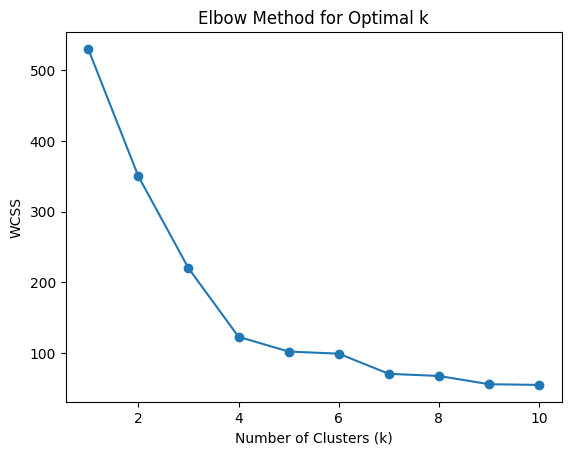

In [ ]:
ks = range(1, 11)  # Values of k
plt.plot(ks, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()


####  What's the best number of clusters?

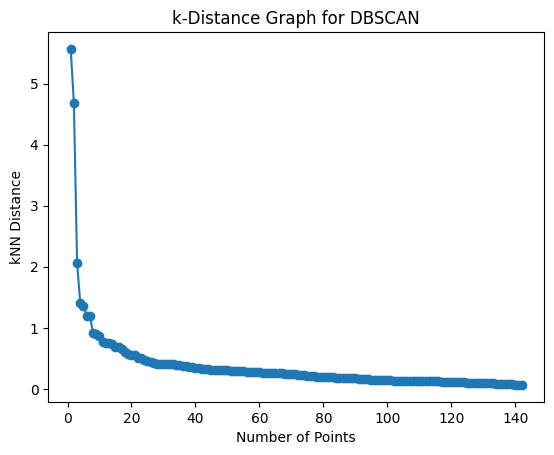

In [ ]:
#i think i got it right with 7knn = NearestNeighbors(n_neighbors=4)  # Choose k+1 neighbors (including the point itself)


---
## Part 2 DBSCAN

#### Use DBSCAN to cluster

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=2.0)

#### Explore and visualize your clustering results

In [ ]:
dbscan.fit(df_transformed)

DBSCAN(eps=2.0)

In [ ]:
silhouette_score(df_transformed, dbscan.labels_)

0.7404359560759209

In [ ]:
orig_df['cluster'] = dbscan.labels_

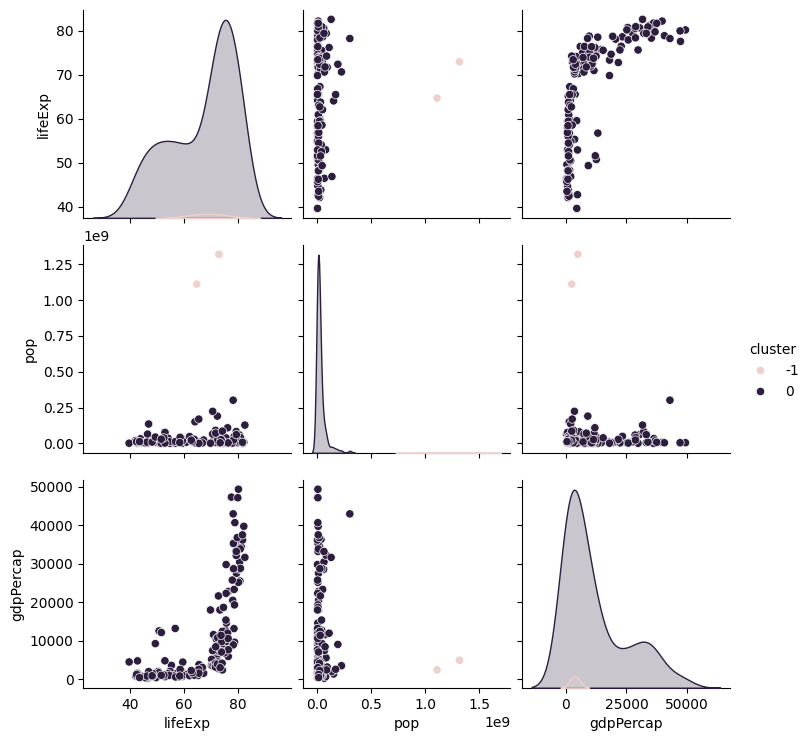

In [ ]:
sns.pairplot(orig_df, hue='cluster')

#### Hyperparameter tune 

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

knn = NearestNeighbors(n_neighbors=4)
knn.fit(df_transformed)
distances, _ = knn.kneighbors(df_transformed)
knn_distances = np.mean(distances[:, 1:], axis=1)  # Exclude the first column (distance to itself)

# Plot the k-distance graph
plt.plot(np.arange(1, len(df_transformed) + 1), np.sort(knn_distances)[::-1], marker='o')
plt.xlabel("Number of Points")
plt.ylabel("kNN Distance")
plt.title("k-Distance Graph for DBSCAN")
plt.show()

#### What are your best hyperparameters?

In [ ]:
#right around eps = 2

---

### Analysis
#### Which algorithm with which hyperparameters would you use to cluster a new country? Why?

I think Kmeans really does a much better job of capturing pieces of the information: continent, population, income ect.  Even if the scores are lower, i think it does a better job.  

## Bonus 🎉

Try a clustering algorithm we didn't cover in class. Scikit-learn has a guide to its clustering algorithms [here](https://scikit-learn.org/stable/modules/clustering.html).